In [616]:
class Point:
  def __init__(self, x, y):
    self.x = x
    self.y = y
    self.isLeftEndpoint = False
    self.segmentId = None
  
  def __str__(self):
    return "(" + str(self.x) + ", " + str(self.y) + ")"

def printPointList(points):
  for p in points:
    print(p, end=" ")
  print()

def receiveInput():
    inputPoints = input().split()

    points = []

    for i in range(0, len(inputPoints) - 1, 2):
      points.append(Point(int(inputPoints[i]), int(inputPoints[i + 1])))

In [617]:
def findBottomMostPoint(points):
  bottomMostPoint = points[0]

  for p in points:
    if p.y < bottomMostPoint.y or (p.y == bottomMostPoint.y and p.x < bottomMostPoint.x):
      bottomMostPoint = p

  return bottomMostPoint

In [618]:
from functools import cmp_to_key

def findOrientation(p0, p1, p2):
  crossProduct = (p1.x - p0.x) * (p2.y - p0.y) - (p2.x - p0.x) * (p1.y - p0.y)
  if crossProduct == 0:
    return "collinear"
  elif crossProduct > 0:
    return "right"
  else:
    return "left"

def findDistance(p0, p1):
  return ((p1.x - p0.x) ** 2 + (p1.y - p0.y) ** 2) ** 0.5

def sortPoints(points, bottomMostPoint):
  def comparePolarAngle(p1, p2):
    orientation = findOrientation(bottomMostPoint, p1, p2)
    if orientation == "collinear":
      if findDistance(bottomMostPoint, p1) <= findDistance(bottomMostPoint, p2):
        return -1
      else:
        return 1
    elif orientation == "right":
      return -1
    else:
      return 1
  sortedPoints = sorted(points, key = cmp_to_key(comparePolarAngle))
  return sortedPoints

def removeCollinearPoints(sortedPoints,bottomMostPoint):
  i = 0
  while i < len(sortedPoints) - 1:
    if findOrientation(bottomMostPoint, sortedPoints[i], sortedPoints[i + 1]) == "collinear":
      sortedPoints.pop(i)
    else:
      i += 1

In [619]:
def findConvexHull(points):
    bottomMostPoint = findBottomMostPoint(points)
    points.remove(bottomMostPoint)
    sortedPoints = sortPoints(points, bottomMostPoint)
    removeCollinearPoints(sortedPoints, bottomMostPoint)
    sortedPoints = [bottomMostPoint] + sortedPoints

    if len(sortedPoints) < 3:
      print("Convex hull is not possible!")

    convexHull = [sortedPoints[0], sortedPoints[1], sortedPoints[2]]
    for i in range(3, len(sortedPoints)):
        while findOrientation(convexHull[-2], convexHull[-1], sortedPoints[i]) != "right":
            convexHull.pop()
        convexHull.append(sortedPoints[i])
    return convexHull

In [620]:
class Segment:
    def __init__(self, p1, p2):
        if p1.x < p2.x:
            self.p1 = p1
            self.p2 = p2
        else:
            self.p1 = p2
            self.p2 = p1

def printSegments(segments):
    print()
    for segment in segments:
        print(segment.p1)
        print("-", end=" ")
        print(segment.p2)
        print()

def findSegments(convexHull):
    segments = []
    for i in range(len(convexHull) - 1):
        segment = Segment(convexHull[i], convexHull[i + 1])
        segments.append(segment)
    segments.append(Segment(convexHull[-1], convexHull[0]))
    
    return segments

In [621]:
def onSegment(p1, p2, p3):
    if ((p3.x <= p2.x and p3.x >= p1.x) or (p3.x <= p1.x and p3.x >= p2.x)):
        if ((p3.y <= p2.y and p3.y >= p1.y) or (p3.y <= p1.y and p3.y >= p2.y)):
            return True
    return False

def segmentsIntersect(p1, p2, p3, p4):
    d1 = findOrientation(p3, p4, p1)
    d2 = findOrientation(p3, p4, p2)
    d3 = findOrientation(p1, p2, p3)
    d4 = findOrientation(p1, p2, p4)

    if ((d1 == 'right' and d2 == 'left') or (d1 == 'left' and d2 == 'right')) and ((d3 == 'right' and d4 == 'left') or (d3 == 'left' and d4 == 'right')): 
        return True
    elif d1 == 'collinear'and onSegment(p3,p4,p1):
        return True
    elif d2 == 'collinear'and onSegment(p3,p4,p2):
        return True
    elif d3 == 'collinear'and onSegment(p1,p2,p3):
        return True
    elif d4 == 'collinear'and onSegment(p1,p2,p4):
        return True
    else:
        return False


In [622]:
class Segment:
    def __init__(self, id, p1, p2, convexHullLabel):
        if p1.x < p2.x:
            self.p1 = Point(p1.x, p1.y)
            self.p2 = Point(p2.x, p2.y)
        else:
            self.p1 = Point(p2.x, p2.y)
            self.p2 = Point(p1.x, p1.y)
        self.p1.isLeftEndpoint = True
        self.p1.segmentId = id
        self.p2.segmentId = id
        self.convexHullLabel = convexHullLabel

    def __str__(self):
        return "(" + str(self.p1.x) + ", " + str(self.p1.y) + ", " + str(self.p1.isLeftEndpoint) + ") - (" + str(self.p2.x) + ", " + str(self.p2.y) + ", " + str(self.p2.isLeftEndpoint)+ ")" + " " + self.convexHullLabel
    
    # return if a segment is below another
    def __gt__(self, other):
        if (min(self.p1.x,other.p1.x)==self.p1.x):
                b = self
                a = other
        else:
            b = other
            a = self
        m2 = (b.p2.y - b.p1.y)/(b.p2.x - b.p1.x)
        m1 = (a.p2.y - a.p1.y)/(a.p2.x - a.p1.x)

        x0 = max(self.p1.x,other.p1.x)
        if not (segmentsIntersect(self.p1,self.p2, other.p1,other.p2)):
            if (findOrientation(b.p1, a.p1, b.p2) == 'right'):
                return True if b == self else False
            elif (findOrientation(b.p1, a.p1, b.p2) == 'left'):
                return False if b == self else True
        else:
            if b.p1.y - m2 * b.p1.x - a.p1.y + m1 * a.p1.x < (m1-m2) * x0:
                return True if b == self else False
            else:
                return False if b == self else True

def printSegments(segments):
    print()
    for segment in segments:
        print(segment)

def findSegments(convexHull, convexHullLabel):
    segments = []
    for i in range(len(convexHull) - 1):
        point1 = convexHull[i]
        point2 = convexHull[i + 1]
        segment = Segment(i, point1, point2, convexHullLabel)
        segments.append(segment)
    point1 = convexHull[-1]
    point2 = convexHull[0]
    segmentId = len(convexHull) - 1
    segments.append(Segment(segmentId, point1, point2, convexHullLabel))
    
    return segments

In [623]:
def findSegmentsEndpoints(segments):
    endpoints = []
    for segment in segments:
        leftEndpoint = segment.p1
        rightEndpoint = segment.p2

        endpoints.append(leftEndpoint)
        endpoints.append(rightEndpoint)
    return endpoints

def sortEndpoints(endpoints):
    def compareEndpoints(p1, p2):
        if p1.x < p2.x:
            return -1
        elif p1.x > p2.x:
            return 1
        else:
            if p1.isLeftEndpoint and not p2.isLeftEndpoint:
                return -1
            elif not p1.isLeftEndpoint and p2.isLeftEndpoint:
                return 1
            else:
                if p1.y < p2.y:
                    return -1
                elif p1.y > p2.y:
                    return 1
                else:
                    return 0
    sortedEndpoints = sorted(endpoints, key = cmp_to_key(compareEndpoints))
    return sortedEndpoints

In [624]:
def adjustBSegmentsId(segmentsB, segmentsA):
    for segment in segmentsB:
        segment.p1.segmentId += len(segmentsA)
        segment.p2.segmentId += len(segmentsA)

In [625]:
from random import random
# Resolve os problemas de inserção de pontos iguais e de retas verticais
def perturbateSegments(segments):
    for segment in segments:
        segment.p1.x += random() * 0.000001
        segment.p2.x += random() * 0.000001
    return segments

In [626]:
class Node():
    def __init__(self, key, parent=None) -> None:
        self.parent = parent
        self.left = None
        self.right = None
        self.height = 1
        self.key = key
    
    def findHeight(self, node): 
        if node == None: return 0
        return node.height
    
    def balanceFactor(node):
        if node == None: return 0
        
        return node.findHeight(node.right) - node.findHeight(node.left)

class AVLTree():
    def __init__(self):
        self.root = None

    def findYZ(self, node):
        Y = node.right if node.findHeight(node.right) > node.findHeight(node.left) else node.left
        Z = Y.right if node.findHeight(Y.right) > node.findHeight(Y.left) else Y.left
        return Y, Z

    def checkAndBalance(self, node):
         # Atualizar balanceamentos
        auxNodeBalancing = node
        while auxNodeBalancing != None and auxNodeBalancing.parent != None:
            balanceFactor = auxNodeBalancing.parent.balanceFactor()
            if balanceFactor < -1:  # Unbalanced to the left
                Y, Z = self.findYZ(auxNodeBalancing.parent)
                # Caso 3
                if auxNodeBalancing.key > auxNodeBalancing.parent.key:
                    self.leftRotate(Y)
                    self.rightRotate(Z)

                # Caso 1
                else: 
                    self.rightRotate(Y)
                
                self.root.height = 1 + max(self.root.findHeight(self.root.left), self.root.findHeight(self.root.right))  # Verificar
            elif balanceFactor > 1:  # Unbalanced to the right
                Y, Z = self.findYZ(auxNodeBalancing.parent)
                # Caso 4
                if auxNodeBalancing.key < auxNodeBalancing.parent.key:
                    self.rightRotate(Y)
                    self.leftRotate(Z)
                else:  # Caso 2
                    self.leftRotate(Y)
                self.root.height = 1 + max(self.root.findHeight(self.root.left), self.root.findHeight(self.root.right))  # Verificar
                    
            auxNodeBalancing = auxNodeBalancing.parent
    
    def preBalanceInsertion(self, key):
        parentNode = self.root
        while parentNode != None:
            if key < parentNode.key:
                if parentNode.left == None:
                    parentNode.left = Node(key, parentNode)
                    return parentNode.left
                parentNode = parentNode.left
            else:
                if parentNode.right == None:
                    parentNode.right = Node(key, parentNode)
                    return parentNode.right
                parentNode = parentNode.right

    def exchangeForPredecessor(self, node):
        currentNode = node.left
        while currentNode != None:
            if currentNode.right != None:
                currentNode = currentNode.right
            else:
                self.removeNode(currentNode.key)
                return currentNode.key
                
    def findPredecessor(self, key):
        currentNode = self.root

        while currentNode != None:
            if key < currentNode.key:
                currentNode = currentNode.left
            elif key > currentNode.key:
                currentNode = currentNode.right
            else:
                auxNode = currentNode
                while auxnode != None:
                    if auxnode.right != None:
                        auxnode = auxnode.right
                    else:
                        return auxnode.key
                return None

    def findSuccessor(self, key):
        currentNode = self.root

        while currentNode != None:
            if key < currentNode.key:
                currentNode = currentNode.left
            elif key > currentNode.key:
                currentNode = currentNode.right
            else:
                auxNode = currentNode
                while auxnode != None:
                    if auxnode.left != None:
                        auxnode = auxnode.left
                    else:
                        return auxnode.key
                return None

    def findKeyToBeRemoved(self, key):
        currentNode = self.root
        if key == self.root.key and self.root.left == None and self.root.right == None:
            self.root = None
            return

        while currentNode != None:
            if key < currentNode.key:
                currentNode = currentNode.left
            elif key > currentNode.key:
                currentNode = currentNode.right
            else:
                if currentNode.left == None and currentNode.right == None:  # Leaf Node
                    auxNode = currentNode
                    if currentNode.key > currentNode.parent.key:
                        currentNode.parent.right = None
                        self.decreaseHeights(auxNode)
                        self.checkAndBalance(auxNode)
                        
                    else:
                        currentNode.parent.left = None
                        self.decreaseHeights(auxNode)
                        self.checkAndBalance(auxNode)

                elif currentNode.left == None and currentNode.right != None:  # Node only has a right child
                    if currentNode.key < currentNode.parent.key:
                        currentNode.parent.left = currentNode.right
                    else:
                        currentNode.parent.right = currentNode.right
                    currentNode.right.parent = currentNode.parent
                    self.decreaseHeights(currentNode.right)
                    self.checkAndBalance(currentNode.right)
                elif currentNode.left != None and currentNode.right == None:  # Node only has a left child
                    if currentNode.key < currentNode.parent.key:
                        currentNode.parent.left = currentNode.left
                    else:
                        currentNode.parent.right = currentNode.left
                    currentNode.left.parent = currentNode.parent
                    self.decreaseHeights(currentNode.left)
                    self.checkAndBalance(currentNode.left)
                    
                else:  # Node has two children
                     currentNode.key = self.exchangeForPredecessor(currentNode)

                    # troca o nó a ser removido com a folha correspondente (seu antecessor) e chama a função novamente a partir da raiz
                currentNode = None

    def leftRotate(self, node):
        node.parent.right = node.left
        node.left = node.parent

        if node.parent != self.root:
            if node.parent.key < node.parent.parent.key:
                node.parent.parent.left = node
            else:
                node.parent.parent.right  = node
        else:
            self.root = node

        aux = node.parent
        node.parent = node.parent.parent
        aux.parent = node

        aux.height = 1 + max(aux.findHeight(aux.left), aux.findHeight(aux.right))
        node.height = 1 + max(node.findHeight(node.left), node.findHeight(node.right))

    def rightRotate(self, node):
        node.parent.left = node.right
        node.right = node.parent

        if node.parent != self.root:
            if node.parent.key < node.parent.parent.key:
                node.parent.parent.left = node
            else:
                node.parent.parent.right  = node
        else:
            self.root = node

        aux = node.parent
        node.parent = node.parent.parent
        aux.parent = node

        aux.height = 1 + max(aux.findHeight(aux.left), aux.findHeight(aux.right))
        node.height = 1 + max(node.findHeight(node.left), node.findHeight(node.right))

    def increaseHeights(self, node):
        auxNodeHeight = node
        while auxNodeHeight.parent != None and auxNodeHeight.parent.height == auxNodeHeight.height:
            auxNodeHeight.parent.height += 1
            auxNodeHeight = auxNodeHeight.parent
    
    def decreaseHeights(self, node):
        auxNodeHeight = node
        while auxNodeHeight != None :
            auxNodeHeight.height = 1 + max(auxNodeHeight.findHeight(auxNodeHeight.left), auxNodeHeight.findHeight(auxNodeHeight.right))
            auxNodeHeight = auxNodeHeight.parent

    def insertNode(self, key):
        if self.root == None:
            self.root = Node(key)
        
        else:
            newNode = self.preBalanceInsertion(key)
            self.increaseHeights(newNode)
            
            # Update Balance
            self.checkAndBalance(newNode)

    def removeNode(self, key):
        self.findKeyToBeRemoved(key)


In [627]:
from bintrees import RBTree

def anySegmentsIntersectTree(convexHullA, convexHullB):
    tree = RBTree()
    AHullSegments = findSegments(convexHullA, "A")
    BHullSegments = findSegments(convexHullB, "B")
    adjustBSegmentsId(BHullSegments, AHullSegments)
    allSegments = perturbateSegments(AHullSegments + BHullSegments)
    allEndpoints = findSegmentsEndpoints(allSegments)
    sortedEndpoints = sortEndpoints(allEndpoints)

    for endpoint in sortedEndpoints:
        if endpoint.isLeftEndpoint:
            segment = allSegments[endpoint.segmentId]
            tree.insert(segment, endpoint.segmentId)
            if (tree.min_key() != segment):
                segmentBelow = tree.prev_key(segment)
                if (segment.convexHullLabel != segmentBelow.convexHullLabel and segmentsIntersect(segment.p1, segment.p2, segmentBelow.p1, segmentBelow.p2)):
                    return True
            if (tree.max_key() != segment):
                segmentAbove = tree.succ_key(segment)
                if (segment.convexHullLabel != segmentAbove.convexHullLabel and segmentsIntersect(segment.p1, segment.p2, segmentAbove.p1, segmentAbove.p2)):
                    return True
        if not endpoint.isLeftEndpoint:
            segment = allSegments[endpoint.segmentId]
            if (tree.min_key() != segment):
                segmentBelow = tree.prev_key(segment)
                if (tree.max_key() != segment):
                    segmentAbove = tree.succ_key(segment)
                    if (segmentBelow.convexHullLabel != segmentAbove.convexHullLabel and segmentsIntersect(segmentBelow.p1, segmentBelow.p2, segmentAbove.p1, segmentAbove.p2)):
                        return True
            tree.remove(segment)
    return False

In [628]:
def findClosestPairOfPoints(convexHullA, convexHullB):
    closestDistance = float("inf")
    closestPair = None
    for i in range(len(convexHullA)):
        for j in range(len(convexHullB)):
            distance = findDistance(convexHullA[i], convexHullB[j])
            if distance < closestDistance:
                closestDistance = distance
                closestPair = Segment("", convexHullA[i], convexHullB[j], "")
    return closestPair

In [629]:
def findBisector(segment, x):
    x1 = (segment.p1.x + segment.p2.x)/2
    y1 = (segment.p1.y + segment.p2.y)/2
    if (segment.p2.x - segment.p1.x) == 0:
        m = 0
    else:
        m = (segment.p2.y - segment.p1.y)/(segment.p2.x - segment.p1.x)
    y = m * (x - x1) + y1
    return y

In [630]:
import matplotlib.pyplot as plt
import numpy as np

def findMinX(convexHull):
    return min(convexHull, key=lambda point: point.x).x

def findMaxX(convexHull):
    return max(convexHull, key=lambda point: point.x).x

def findXInterval(convexHull):
    diff = abs(findMaxX(convexHull) - findMinX(convexHull))
    return (findMinX(convexHull) - diff * 0.25, findMaxX(convexHull) + diff * 0.25)

def findMinY(convexHull):
    return min(convexHull, key=lambda point: point.y).y

def findMaxY(convexHull):
    return max(convexHull, key=lambda point: point.y).y

def findYInterval(convexHull):
    diff = abs(findMaxY(convexHull) - findMinY(convexHull))
    return (findMinY(convexHull) - diff * 0.25, findMaxY(convexHull) + diff * 0.25)

def plotConvexHull(points, convexHull, color):
    x = [point.x for point in points]
    y = [point.y for point in points]
    plt.scatter(x, y, color=color)
    for i in range(len(convexHull)):
        p1 = convexHull[i]
        p2 = convexHull[(i + 1) % len(convexHull)]
        plt.plot([p1.x, p2.x], [p1.y, p2.y], color, marker='o')

def findAndPlotModel(points, points2, title):
    convexHullA = findConvexHull(points)
    convexHullB = findConvexHull(points2)

    if (anySegmentsIntersectTree(convexHullA, convexHullB) == True):
        print("As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.")

    xInterval = findXInterval(convexHullA + convexHullB)
    yInterval = findYInterval(convexHullA + convexHullB)
    closestPair = findClosestPairOfPoints(convexHullA, convexHullB)
    x = np.linspace(xInterval[0], xInterval[1], 100)
    y = findBisector(closestPair, x)
    
    fig, ax = plt.subplots(figsize=(16, 10), dpi=160)
    plotConvexHull(points, convexHullA, 'r')
    plotConvexHull(points2, convexHullB, 'b')
    ax.plot([closestPair.p1.x, closestPair.p2.x], [closestPair.p1.y, closestPair.p2.y], 'g', marker='o')
    ax.plot(x, y, 'k')
    ax.set_title(title, fontsize=20)
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_xlim(xInterval)
    ax.set_ylim(yInterval)
    ax.tick_params(axis='both', which='major', labelsize=16)

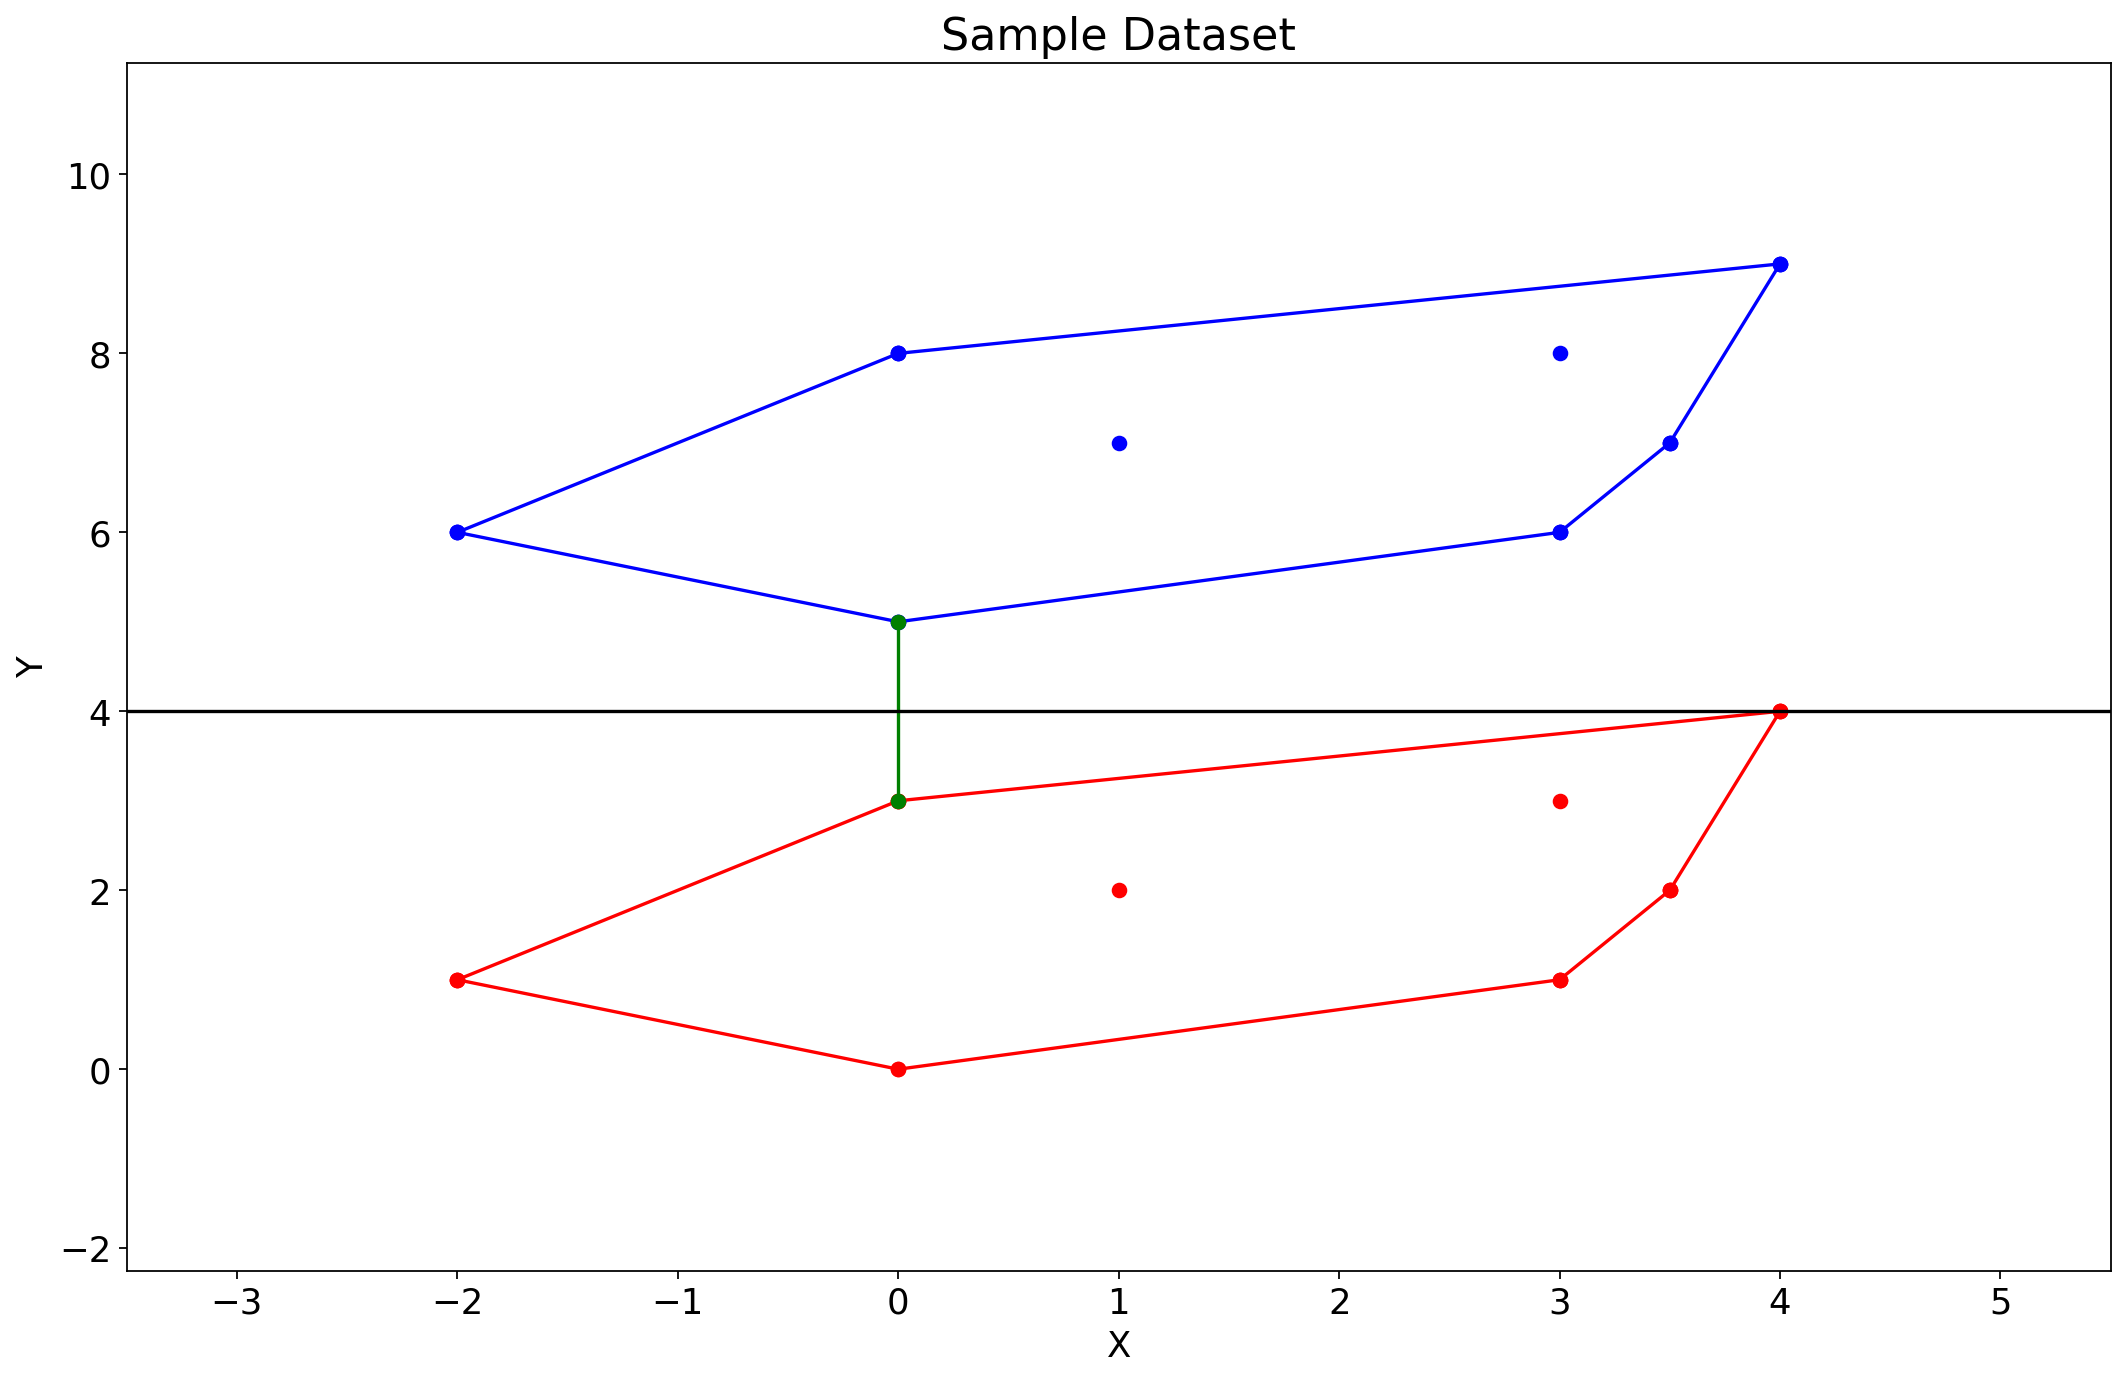

In [631]:
points = [(0, 3), (1, 2), (4, 4), (0, 0), (3, 1), (3, 3), (3.5, 2), (-2, 1)]
points = [Point(x, y) for x, y in points]

points2 = [(0, 8), (1, 7), (4, 9), (0, 5), (3, 6), (3, 8), (3.5, 7), (-2, 6)]
points2 = [Point(x, y) for x, y in points2]
findAndPlotModel(points, points2, "Sample Dataset")

As envoltórias convexas se interceptam, portanto, os conjuntos não são linearmente separáveis.


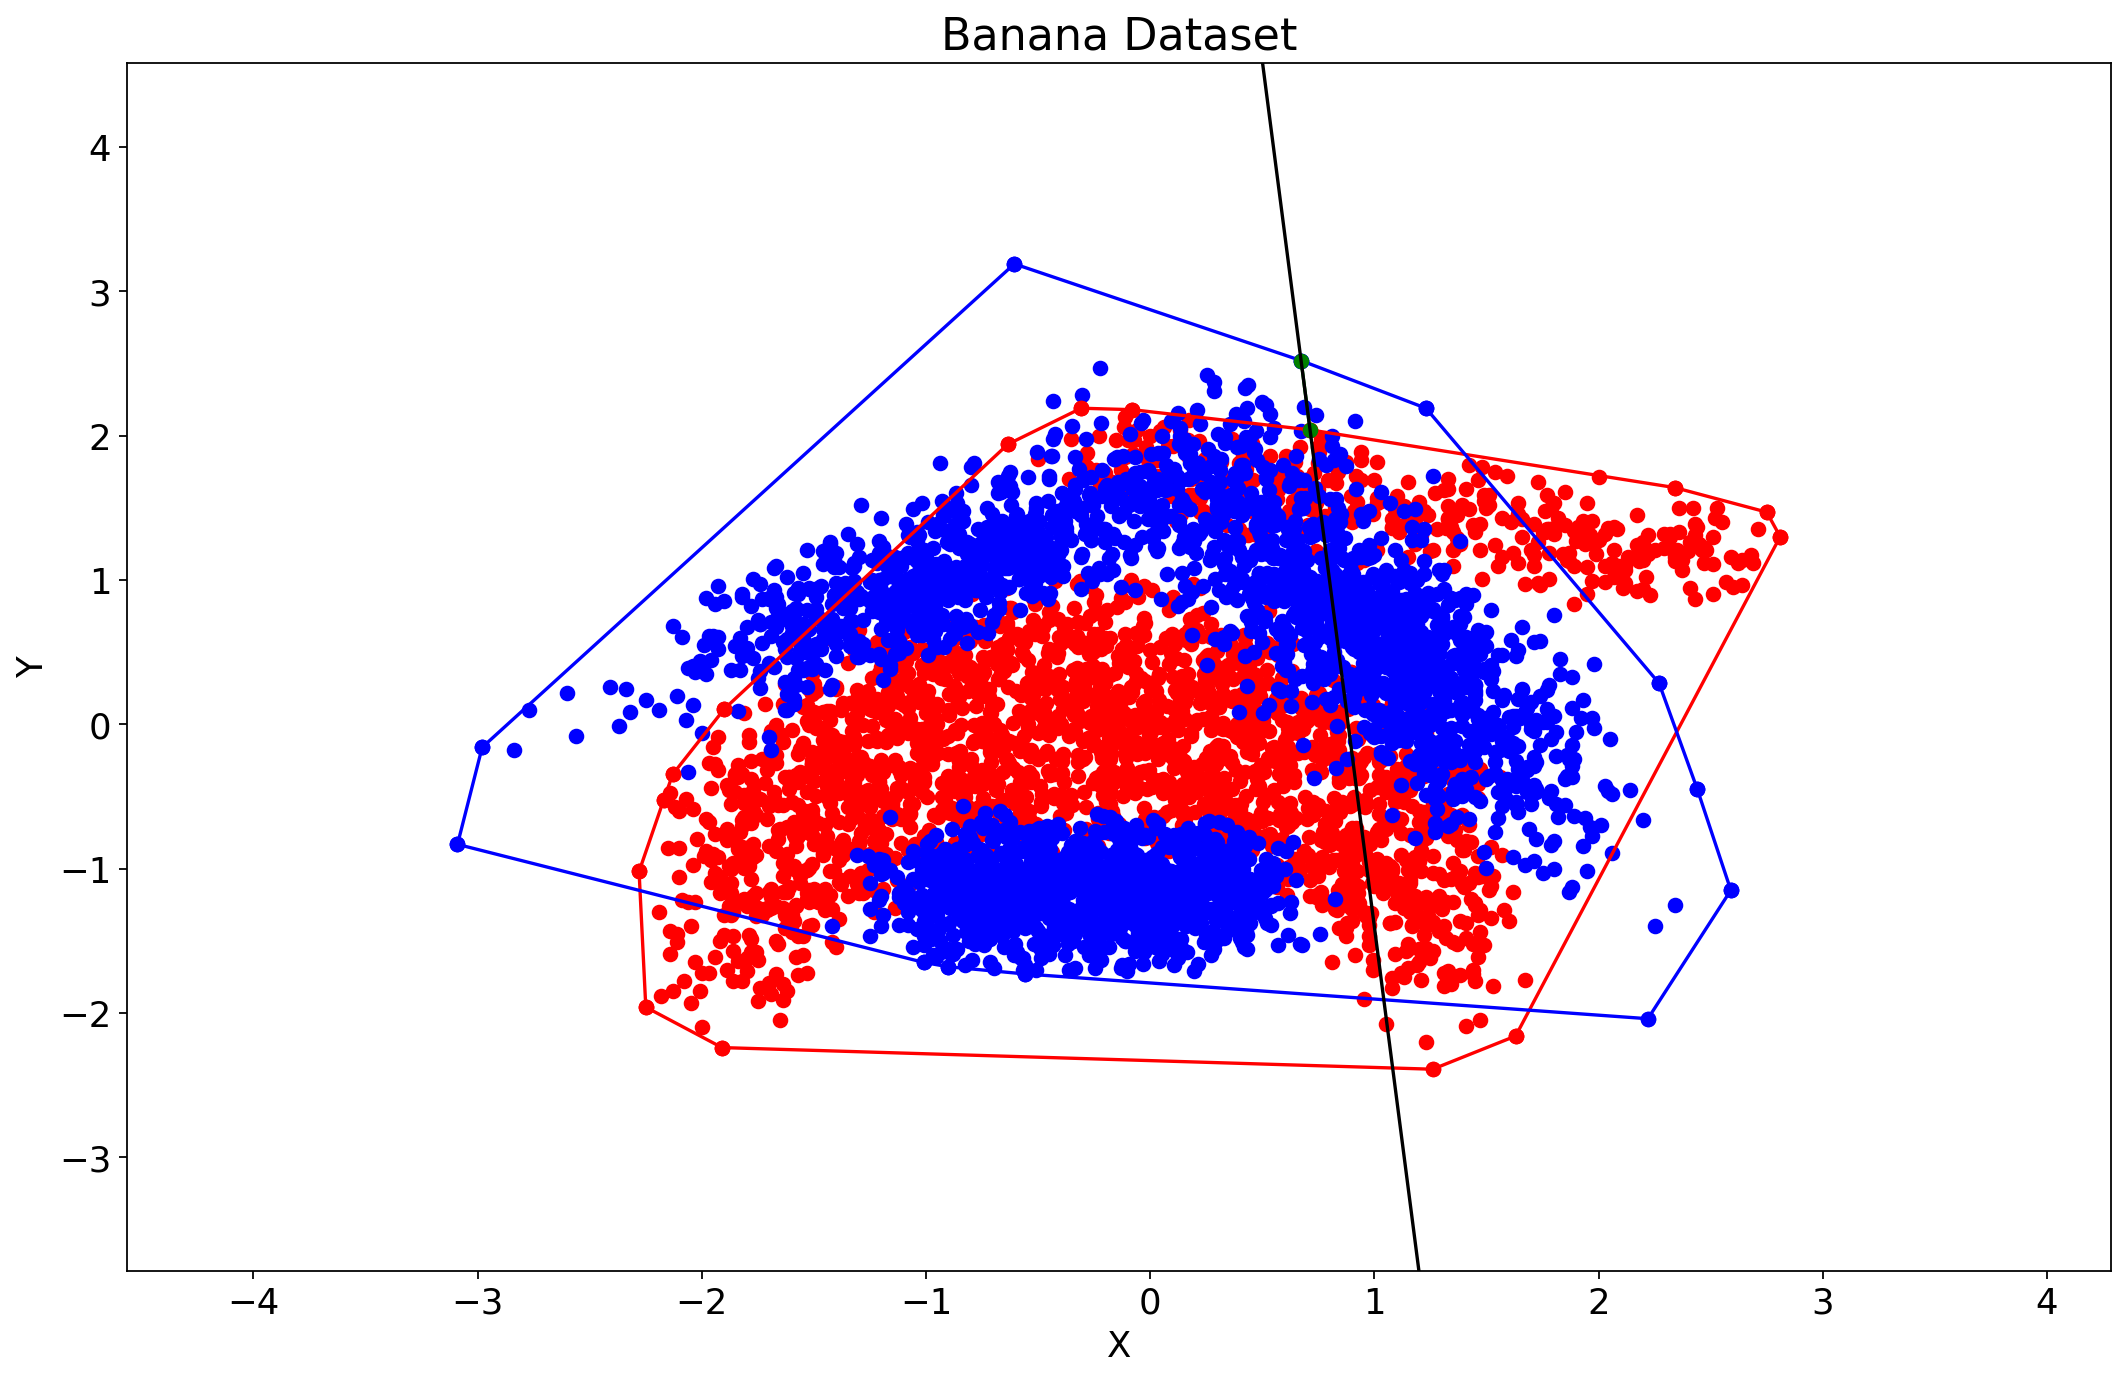

In [632]:
import pandas as pd
banana = pd.read_csv('./datasets/banana.csv')
banana
class1 = banana[banana['Class'] == 1.0]
class2 = banana[banana['Class'] == -1.0]
points = [Point(class1.iloc[i, 0], class1.iloc[i, 1]) for i in range(len(class1))]
points2 = [Point(class2.iloc[i, 0], class2.iloc[i, 1]) for i in range(len(class2))]

findAndPlotModel(points, points2, "Banana Dataset")